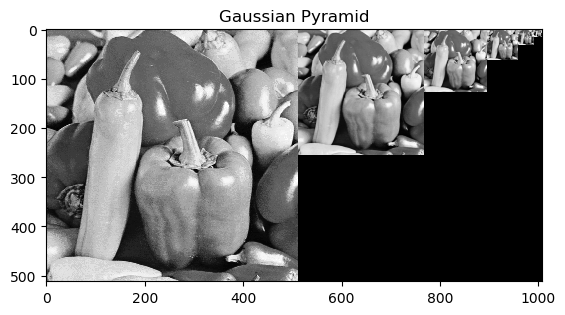

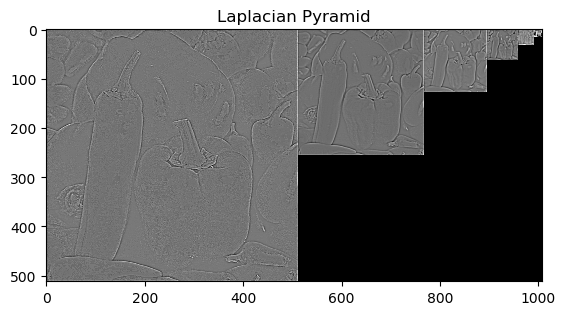

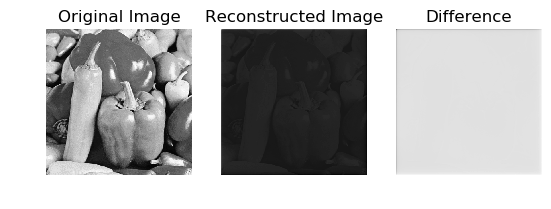

In [1]:
using Images
using PyPlot


# Create a gaussian filter
function makegaussianfilter(size::Array{Int,2},sigma::Float64)
  n_rows = size[1]
  n_columns = size[2]

  x = -floor(n_rows/2): floor(n_rows/2)
  y = -floor(n_columns/2): floor(n_columns/2)

  f = zeros(n_rows, n_columns)

  for i = 1: n_rows
      for j = 1: n_columns
          f[i, j] = 1/(2*pi*sigma) * exp(-(x[i]^2 + y[j]^2)/2/sigma^2)
      end
  end
  f = f/sum(abs.(f))
  return f::Array{Float64,2}
end

f = makegaussianfilter(reshape([5,5],2,1),1.4)

# Create a binomial filter
function makebinomialfilter(size::Array{Int,2})
  n_rows = size[1]
  n_columns = size[2]

  w_rows = zeros(n_rows, 1)
  w_columns = zeros(1, n_columns)

  for i = 1: n_rows
      w_rows[i, 1] = factorial(n_rows-1)/ factorial(i-1)/ factorial(n_rows-i)
  end

  for j = 1: n_columns
      w_columns[1, j] = factorial(n_columns-1)/ factorial(j-1)/ factorial(n_columns-j)
  end

  f = w_rows * w_columns

  f = f / sum(f)
  return f::Array{Float64,2}
end

makebinomialfilter(reshape([5,5],2,1))

# Downsample an image by a factor of 2
function downsample2(A::Array{Float64,2})
  D = zeros(ceil(Int, size(A, 1)/2), ceil(Int, size(A,2)/2))
  D[:, :] = A[1:2:end, 1:2:end]

  return D::Array{Float64,2}
end

# Upsample an image by a factor of 2
function upsample2(A::Array{Float64,2},fsize::Array{Int,2})
  
  up_sampling_Matrix = zeros(2*size(A, 1), 2*size(A, 2))
  up_sampling_Matrix[1:2:end, 1:2:end] = A

  f = makebinomialfilter(fsize)
  U = 4 * imfilter(up_sampling_Matrix, centered(f), "symmetric")
  
  return U::Array{Float64,2}
end

# Build a gaussian pyramid from an image.
# The output array should contain the pyramid levels in decreasing sizes.
function makegaussianpyramid(im::Array{Float32,2},nlevels::Int,fsize::Array{Int,2},sigma::Float64)
  f_gaussian = makegaussianfilter(fsize, sigma)
  G = Array{Array{Float64,2}}(undef, nlevels)
  G[1] = im
  for i = 2: nlevels
      G[i] = imfilter(G[i-1], centered(f_gaussian), "symmetric")
      G[i] = downsample2(G[i])
  end
  return G::Array{Array{Float64,2},1}
end

# Display a given image pyramid (laplacian or gaussian)
function displaypyramid(P::Array{Array{Float64,2},1})
  n_rows = [size(P[i],1) for i = 1:length(P)]
  n_columns = [size(P[i],2) for i = 1:length(P)]

  P_together = zeros(n_rows[1], sum(n_columns))

  for i = 1: length(P)
      max = maximum(P[i])
      min = minimum(P[i])
      P[i] = (P[i] .- min) / (max - min)
      if i == 1
          P_together[1:end, 1:n_columns[1]] = P[i]
      else
          P_together[1:n_rows[i], sum(n_columns[1:i-1])+1 : sum(n_columns[1:i-1]) + n_columns[i]] = P[i]
      end
  end

  figure()
  imshow(P_together, "gray", interpolation = "none")
  title("Pyramids")
  gcf()
  return nothing
end

# Build a laplacian pyramid from a gaussian pyramid.
# The output array should contain the pyramid levels in decreasing sizes.
function makelaplacianpyramid(G::Array{Array{Float64,2},1},nlevels::Int,fsize::Array{Int,2})
  L = Array{Array{Float64,2}}(undef, nlevels)

  for i = 1:length(G)-1
      L[i] = G[i] - upsample2(G[i+1],fsize)
  end

  L[end] = G[end]
  return L::Array{Array{Float64,2},1}
end

# Amplify frequencies of the first two layers of the laplacian pyramid
function amplifyhighfreq2(L::Array{Array{Float64,2},1})
  scaling_factor = [1 1]
  A = deepcopy(L)
  A[1] = scaling_factor[1] * L[1]
  A[2] = scaling_factor[2] * L[2]
  return A::Array{Array{Float64,2},1}
end

# Reconstruct an image from the laplacian pyramid
function reconstructlaplacianpyramid(L::Array{Array{Float64,2},1},fsize::Array{Int,2})
  G = Array{Array{Float64,2}}(undef, length(L))
  G[end] = L[end]
  for i = length(L)-1:-1:1
      G[i] = L[i] + upsample2(G[i+1], fsize)
      
  end
  im = G[1]
  
  return im::Array{Float64,2}
end


# Problem 1: Image Pyramids and Image Sharpening

function problem1()
  # parameters
  fsize = reshape([5, 5], 2, 1)
  sigma = 1.4
  nlevels = 6

  # load image
  im = PyPlot.imread("a2p1.png")

  # create gaussian pyramid
  G = makegaussianpyramid(im,nlevels,fsize,sigma)

  # display gaussianpyramid
  displaypyramid(G)
  title("Gaussian Pyramid")

  # create laplacian pyramid
  L = makelaplacianpyramid(G,nlevels,fsize)

  # dispaly laplacian pyramid
  displaypyramid(L)
  title("Laplacian Pyramid")


  # amplify finest 2 subands
  L_amp = amplifyhighfreq2(L)

  # reconstruct image from laplacian pyramid
  im_rec = reconstructlaplacianpyramid(L_amp,fsize)

  # display original and reconstructed image
  figure()
  subplot(131)
  imshow(im,"gray",interpolation="none")
  axis("off")
  title("Original Image")
  subplot(132)
  imshow(im_rec,"gray",interpolation="none")
  axis("off")
  title("Reconstructed Image")
  subplot(133)
  imshow(im-im_rec,"gray",interpolation="none")
  axis("off")
  title("Difference")
  gcf()
  return 
end

problem1()
